In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="tqdm")

import logging
logging.getLogger('rpy2').setLevel(logging.WARNING)

%load_ext autoreload
%autoreload 2
# from ipython import autoreload
import numpy as np
import itertools
import yaml
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import causallearn
from causallearn.graph.Edge import Edge
from causallearn.graph.Endpoint import Endpoint
from causallearn.search.ConstraintBased.FCI import fci
import random

from clustercausal.algorithms.ClusterPC import ClusterPC
from clustercausal.algorithms.ClusterFCI import ClusterFCI
from clustercausal.clusterdag.ClusterDAG import ClusterDAG
from clustercausal.experiments.Evaluator import Evaluator
# from clustercausal.experiments.ExperimentRunner import ExperimentRunner
from clustercausal.experiments.ExperimentRunnervsFCITiers import (
    ExperimentRunner,
)
from clustercausal.utils.Utils import *
from clustercausal.experiments.Utils import load_experiment_folder
from clustercausal.utils.Utils import *
from clustercausal.experiments.Simulator import Simulator
from clustercausal.algorithms.FCITiers import fci_tiers

c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


In [2]:
# # cluster_dag = ClusterDAG(cluster_mapping = {'C1' : ['X1', 'X2'], 'C2' : ['X3', 'X4'], 'C3' : ['X5', 'X6']}, \
# #                          cluster_edges = [('C1', 'C2'), ('C2', 'C3')], \
# #                          cluster_bidirected_edges=[('C2', 'C3')])
# cluster_dag = ClusterDAG(cluster_mapping = {'C1' : ['X1', 'X2'], 'C2' : ['X3', 'X4'], 'C3' : ['X5', 'X6'], 'C4' : ['X7', 'X8']}, \
#                          cluster_edges = [('C1', 'C2'), ('C2', 'C3'), ('C1', 'C4')], \
#                          cluster_bidirected_edges=[('C2', 'C3'), ('C3', 'C4')])
# # cluster_dag.cluster_graph.draw_pydot_graph()

In [3]:
simulation = Simulator(n_nodes = 20, n_edges = 20, n_clusters = 4, seed = 115)
cluster_dag = simulation.run_with_latents()

INFO: Finished synthetic dataset


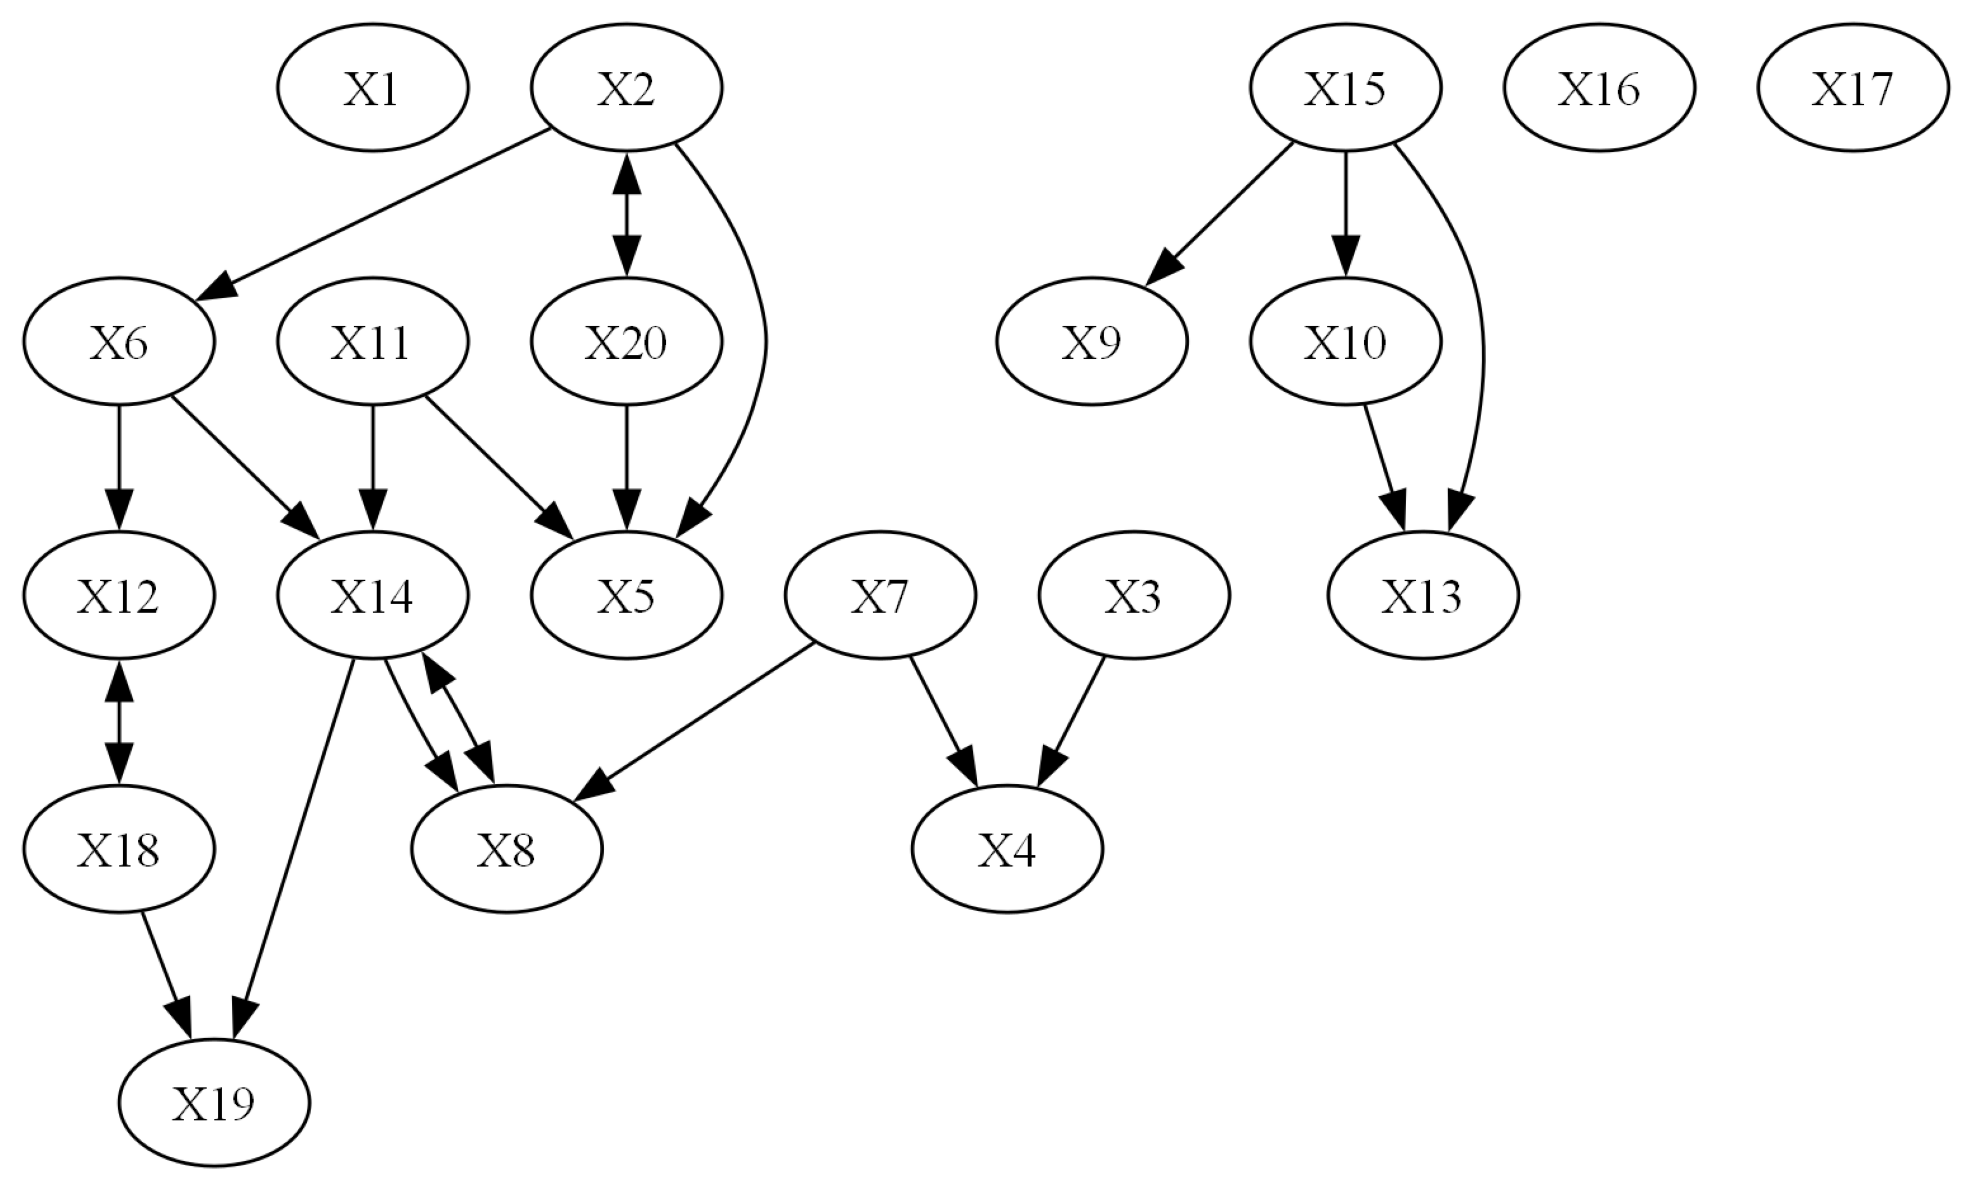

In [4]:
cluster_dag.true_dag.draw_pydot_graph()

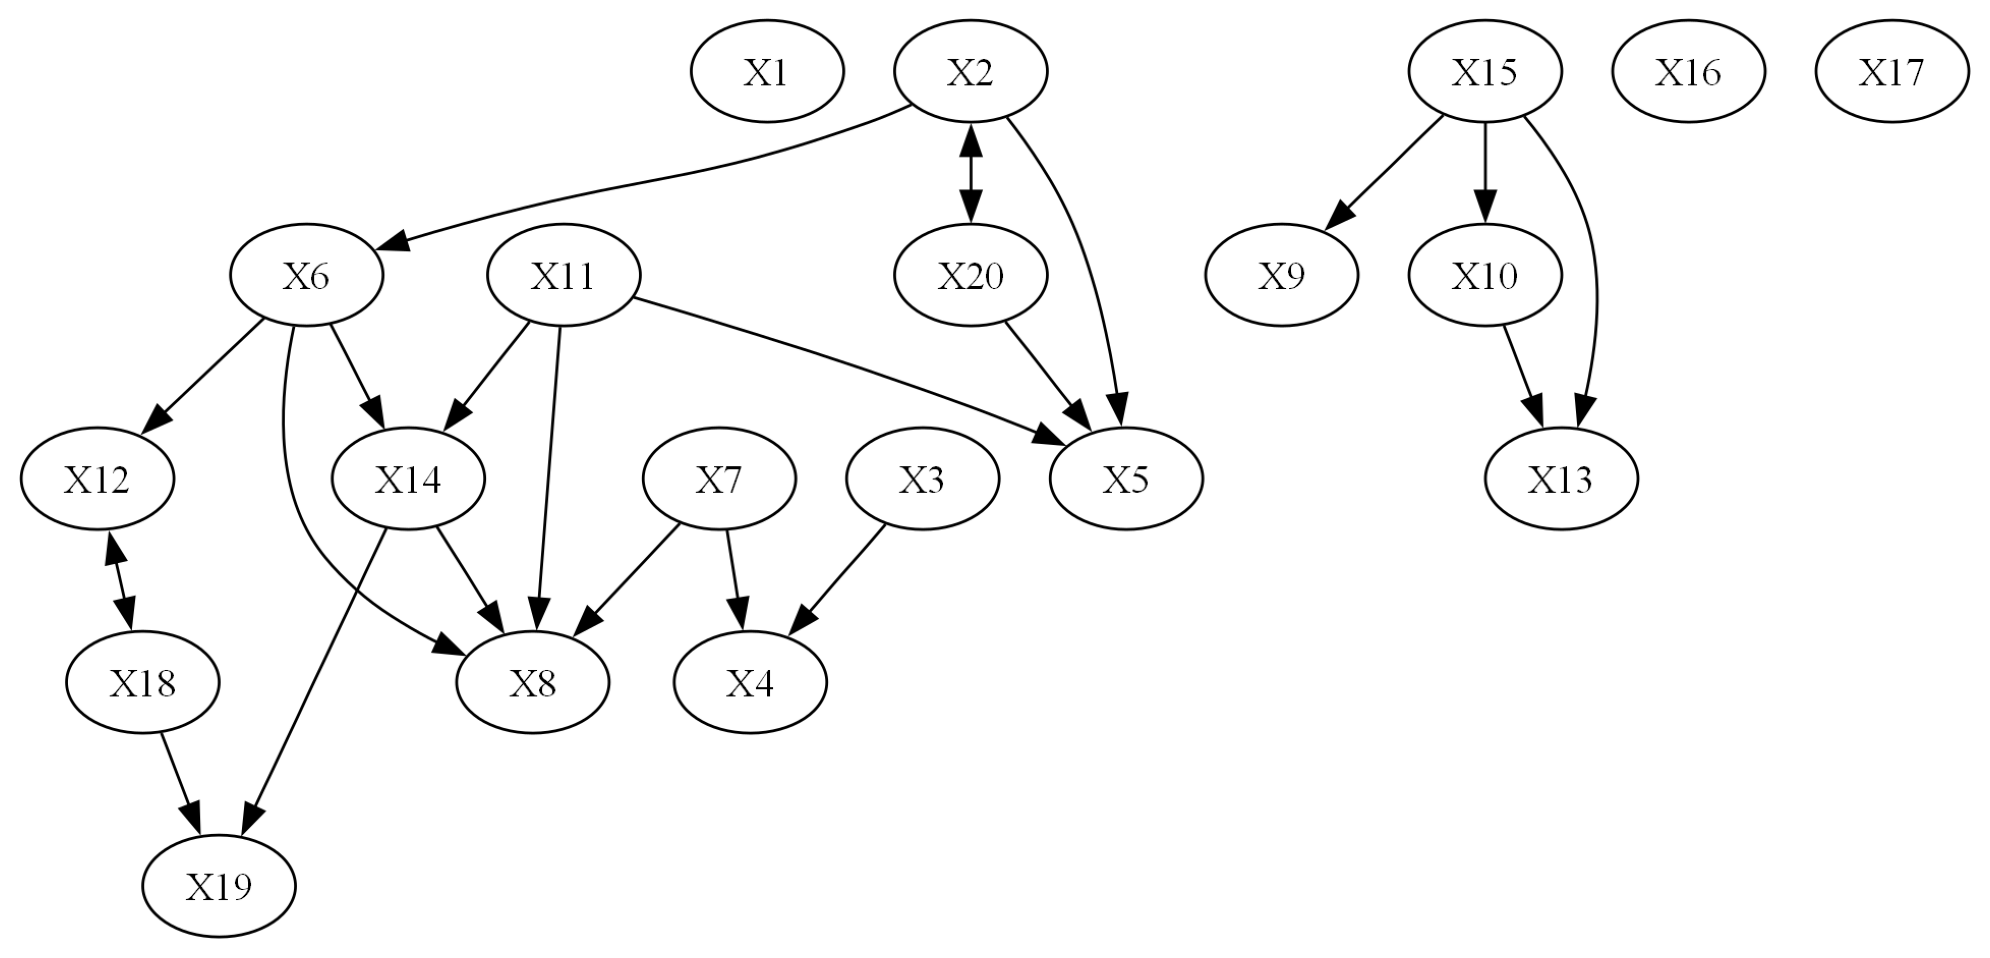

In [5]:
cluster_dag.true_mag.draw_pydot_graph()

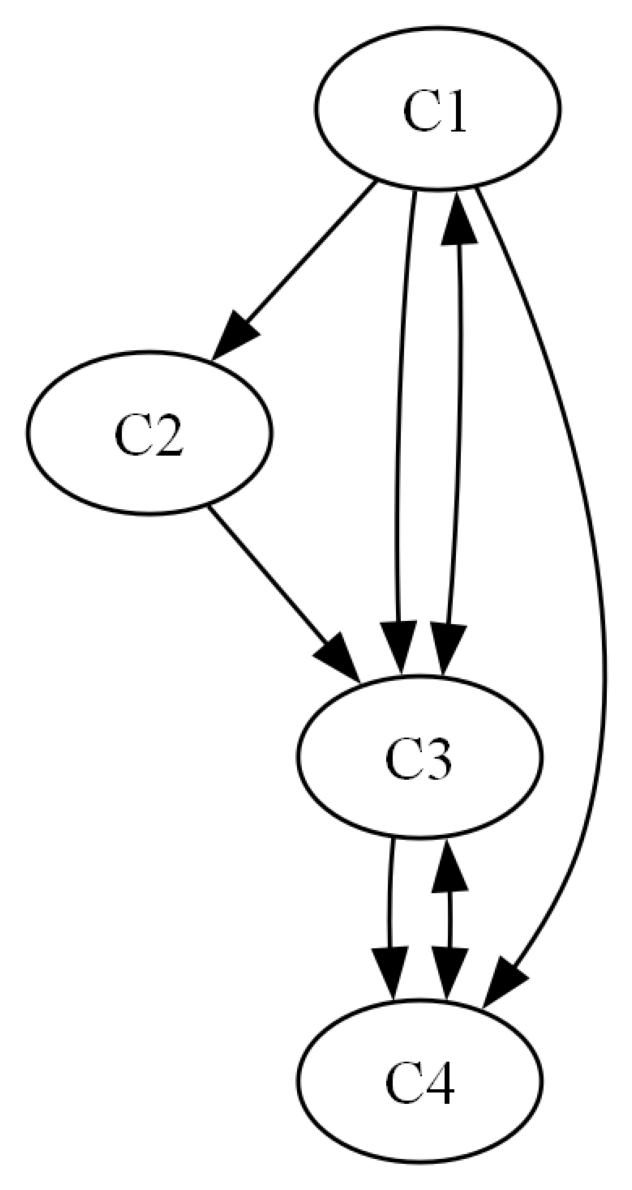

In [6]:
cluster_dag.cluster_graph.draw_pydot_graph()

In [7]:
# cluster_dag.cdag_to_circle_mpdag()
# cluster_dag.cg.draw_pydot_graph()

In [8]:
cluster_dag.cluster_mapping

{'C1': ['X2', 'X3', 'X7', 'X11', 'X20', 'X15', 'X18', 'X1'],
 'C2': ['X16', 'X17', 'X6', 'X4', 'X5', 'X9'],
 'C3': ['X10', 'X12', 'X14'],
 'C4': ['X13', 'X8', 'X19']}

### Evaluate

In [9]:
cluster_fci = ClusterFCI(cluster_dag, dataset = cluster_dag.data, alpha = 0.05)
cluster_cg, cluster_edges = cluster_fci.run()

C4 phase, Depth=5, working on node 18: 100%|██████████| 3/3 [00:00<00:00, 2116.91it/s, duration: 0.05sec]


X4 --> X5
X7 --> X4
X4 --> X10
X4 --> X14
X7 --> X5
X5 --> X13
X5 --> X14
X7 --> X6
X9 --> X12
X10 --> X13
X13 --> X19


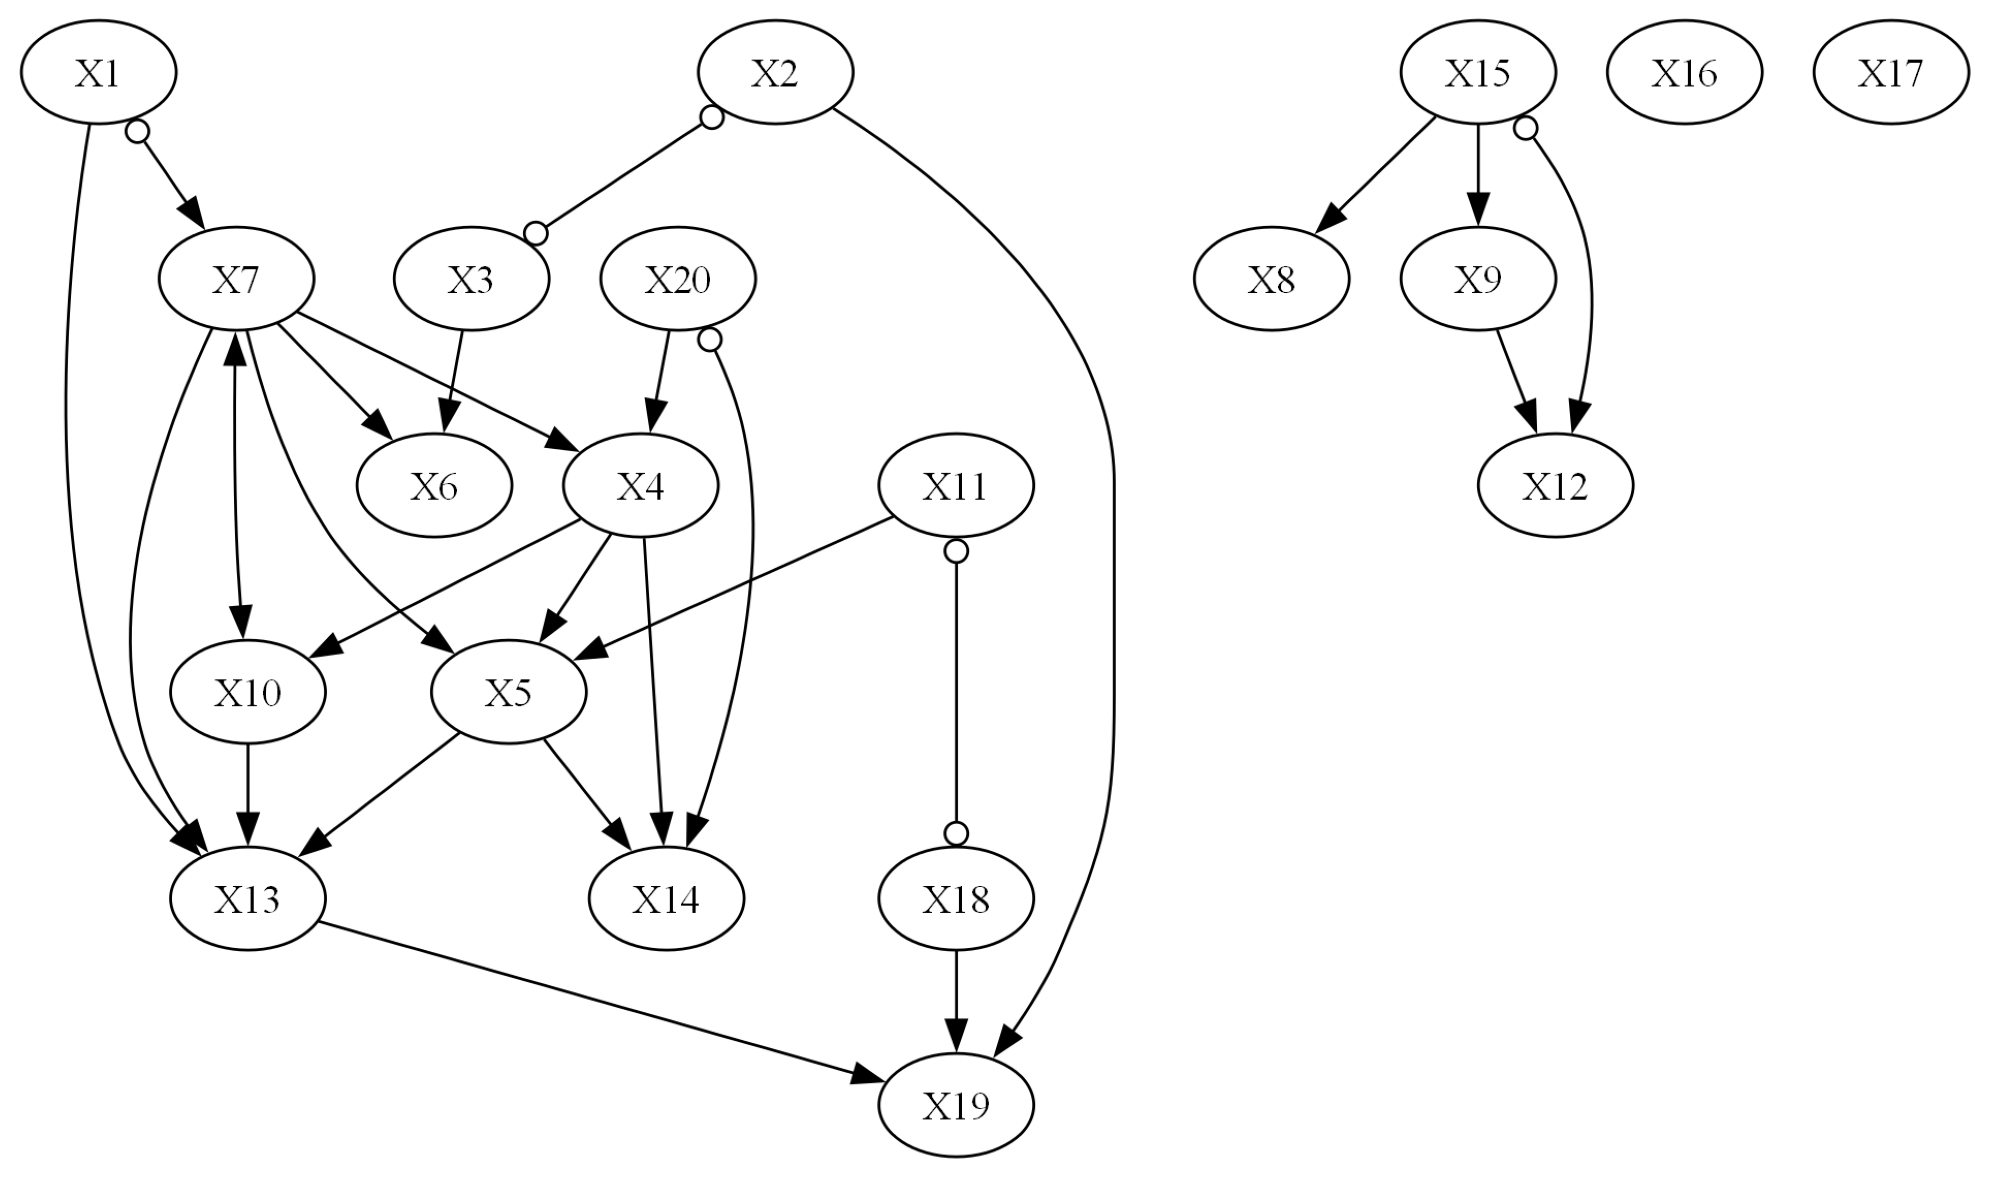

In [10]:
cluster_cg.draw_pydot_graph()

In [11]:
base_G, base_edges = fci(dataset = cluster_dag.data, alpha = 0.05, verbose = False)
base_cg = CausalGraph(len(base_G.get_node_names()))
base_cg.G = base_G

Depth=4, working on node 19: 100%|██████████| 20/20 [00:00<00:00, 1536.66it/s]

X13 --> X7
X13 --> X19


In [12]:
tiers = cluster_dag.get_cluster_topological_ordering()
cluster_mapping = cluster_dag.cluster_mapping
fci_tiers_cg, fci_tiers_edges = fci_tiers(tiers = tiers, \
                                          cluster_mapping = cluster_mapping, \
                                          cdag = cluster_dag, \
                                            dataset = cluster_dag.data, alpha = 0.05, \
                                                verbose = False)

Depth=4, working on node 19: 100%|██████████| 20/20 [00:00<?, ?it/s]          

X5 --> X4
X4 --> X10
X4 --> X14
X5 --> X13
X5 --> X14
X9 --> X12
X10 --> X13
X13 --> X19


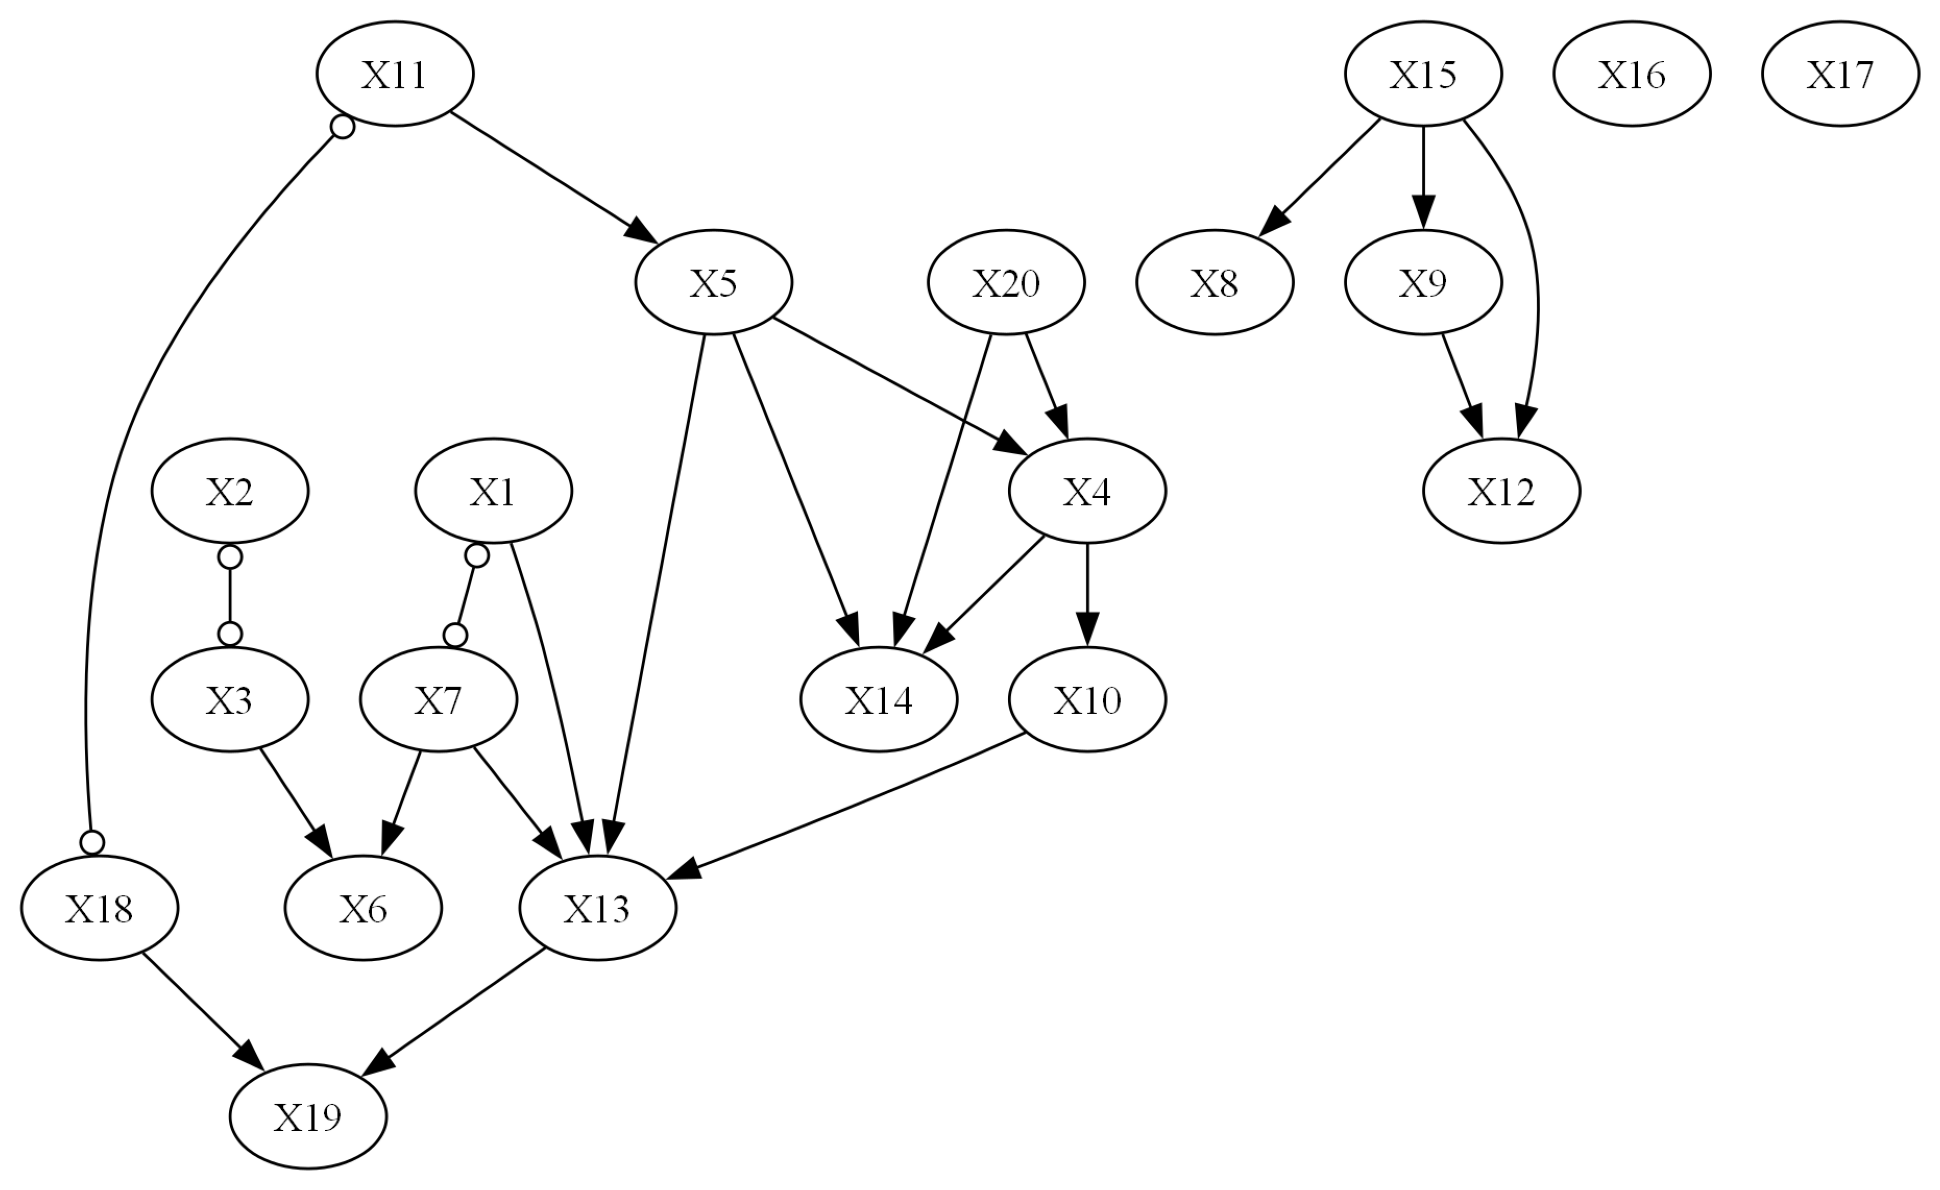

In [13]:
fci_tiers_cg.draw_pydot_graph()

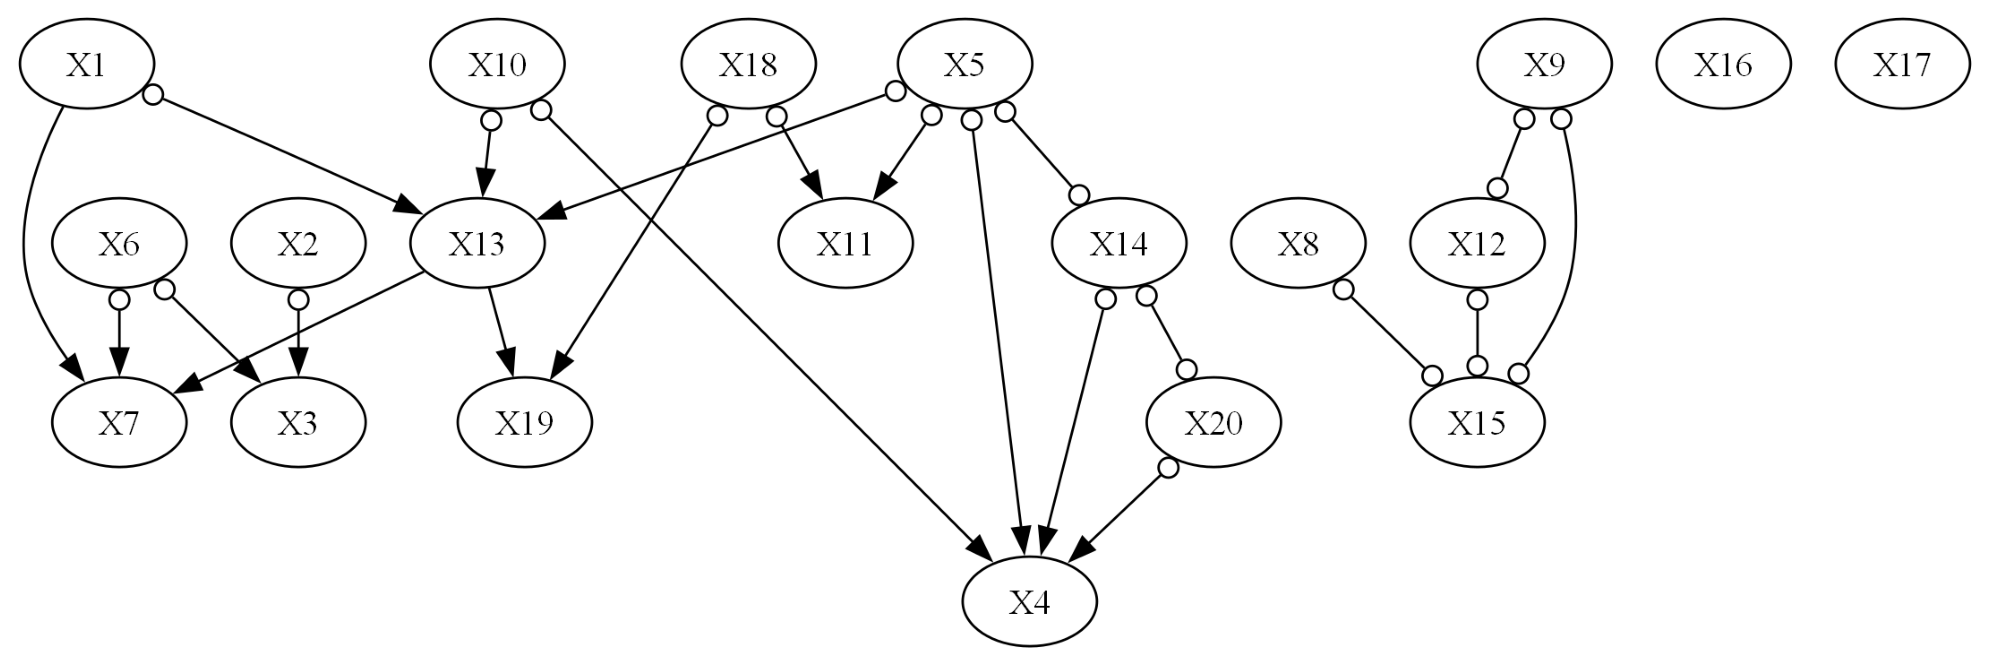

In [14]:
base_cg.draw_pydot_graph()

In [15]:
# Evaluator works on the GeneralGraph object of a CausalGraph object, which is cg.G, cluster_dag.true_dag.G or pc_est_graph.G
eval_fci = Evaluator(truth = cluster_dag.true_mag.G, est = base_cg.G)
adjacency_confusion, arrow_confusion, shd, sid = eval_fci.get_causallearn_metrics(sid = False)
print("Adjacency confusion: ", adjacency_confusion)
print("Arrow confusion: ", arrow_confusion)
print("SHD: ", shd)
print("SID: ",  sid)

Adjacency confusion:  {'true_positive': 4, 'false_positive': 18, 'false_negative': 17, 'true_negative': 151, 'precision': 0.18181818181818182, 'recall': 0.19047619047619047, 'f1_score': 0.18604651162790697}
Arrow confusion:  {'true_positive': 2.0, 'false_positive': 14.0, 'false_negative': 21.0, 'true_negative': 363.0, 'precision': 0.125, 'recall': 0.08695652173913043, 'f1_score': 0.10256410256410256, 'true_positive_ce': 2.0, 'false_positive_ce': 1.0, 'false_negative_ce': 2.0, 'true_negative_ce': 395.0, 'precision_ce': 0.6666666666666666, 'recall_ce': 0.5, 'f1_score_ce': 0.5714285714285715}
SHD:  36
SID:  {'sid_lower': None}


In [16]:
# Evaluator works on the GeneralGraph object of a CausalGraph object, which is cg.G, cluster_dag.true_dag.G or pc_est_graph.G
eval_c_fci = Evaluator(truth = cluster_dag.true_mag.G, est = cluster_cg.G)
adjacency_confusion, arrow_confusion, shd, sid = eval_c_fci.get_causallearn_metrics(sid = False)
print("Adjacency confusion: ", adjacency_confusion)
print("Arrow confusion: ", arrow_confusion)
print("SHD: ", shd)
print("SID: ",  sid)

Adjacency confusion:  {'true_positive': 5, 'false_positive': 21, 'false_negative': 16, 'true_negative': 148, 'precision': 0.19230769230769232, 'recall': 0.23809523809523808, 'f1_score': 0.21276595744680848}
Arrow confusion:  {'true_positive': 5.0, 'false_positive': 20.0, 'false_negative': 18.0, 'true_negative': 357.0, 'precision': 0.2, 'recall': 0.21739130434782608, 'f1_score': 0.20833333333333331, 'true_positive_ce': 5.0, 'false_positive_ce': 0.0, 'false_negative_ce': 0.0, 'true_negative_ce': 395.0, 'precision_ce': 1.0, 'recall_ce': 1.0, 'f1_score_ce': 1.0}
SHD:  37
SID:  {'sid_lower': None}


In [17]:
# Evaluator works on the GeneralGraph object of a CausalGraph object, which is cg.G, cluster_dag.true_dag.G or pc_est_graph.G
eval_fci_tiers = Evaluator(truth = cluster_dag.true_mag.G, est = fci_tiers_cg.G)
adjacency_confusion, arrow_confusion, shd, sid = eval_fci_tiers.get_causallearn_metrics(sid = False)
print("Adjacency confusion: ", adjacency_confusion)
print("Arrow confusion: ", arrow_confusion)
print("SHD: ", shd)
print("SID: ",  sid)

Adjacency confusion:  {'true_positive': 4, 'false_positive': 18, 'false_negative': 17, 'true_negative': 151, 'precision': 0.18181818181818182, 'recall': 0.19047619047619047, 'f1_score': 0.18604651162790697}
Arrow confusion:  {'true_positive': 4.0, 'false_positive': 15.0, 'false_negative': 19.0, 'true_negative': 362.0, 'precision': 0.21052631578947367, 'recall': 0.17391304347826086, 'f1_score': 0.1904761904761905, 'true_positive_ce': 4.0, 'false_positive_ce': 0.0, 'false_negative_ce': 0.0, 'true_negative_ce': 396.0, 'precision_ce': 1.0, 'recall_ce': 1.0, 'f1_score_ce': 1.0}
SHD:  35
SID:  {'sid_lower': None}


Example

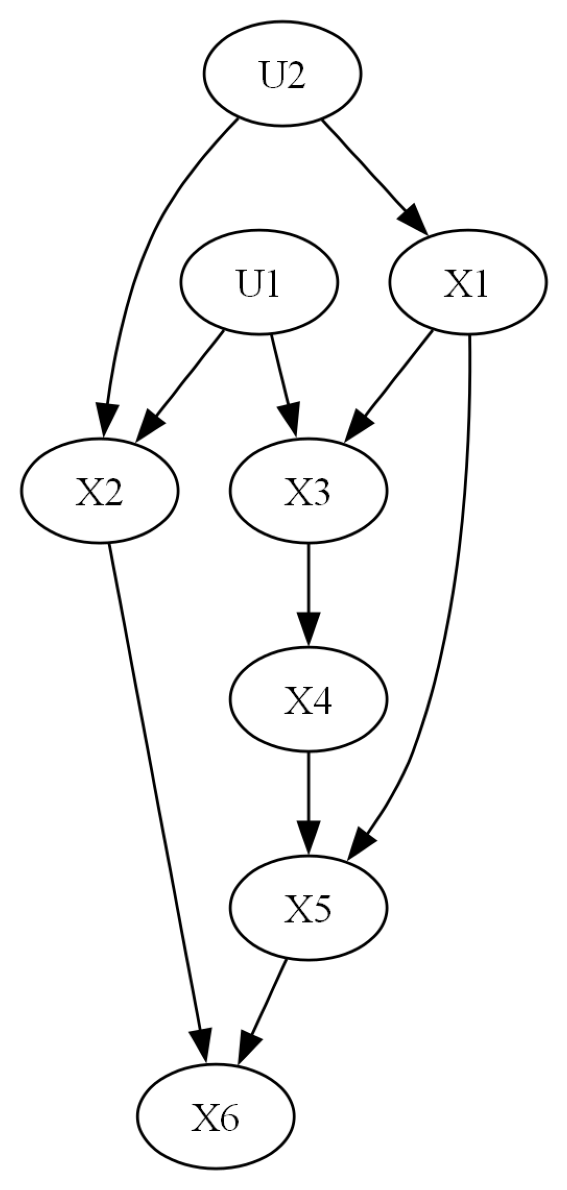

In [18]:
# List of node names
node_names = ["X1", "X2", "X3", "X4", "X5", "X6", "U1", "U2"]

# Parent dictionary
# Make sure nodes are put into topological ordering
parent_dict = {
    "X1": ["U2"],           
    "X2": ["U1", "U2"],
    "X3": ["U1", "X1"],               
    "X4": ["X3"], 
    "X5": ["X1", "X4"],
    "X6": ["X2", "X5"],
    "U1": [],
    "U2": []
}

# Call the make_graph function from Utils
truth, W = make_graph(node_names, parent_dict)

truth.draw_pydot_graph()

In [19]:
true_mag = truth
true_mag.G.remove_node(ClusterDAG.get_node_by_name('U1', cg = truth))
true_mag.G.remove_node(ClusterDAG.get_node_by_name('U2', cg = truth))
# Add edge due to inducing path
node1 = ClusterDAG.get_node_by_name('X2', cg = truth)
node2 = ClusterDAG.get_node_by_name('X3', cg = truth)
edge = Edge(node1 = node1, node2 = node2, end1 = Endpoint.ARROW, end2 = Endpoint.ARROW)
true_mag.G.add_edge(edge)
# Add bidirected edge due to latent confounding
node1 = ClusterDAG.get_node_by_name('X1', cg = truth)
node2 = ClusterDAG.get_node_by_name('X2', cg = truth)
edge = Edge(node1 = node1, node2 = node2, end1 = Endpoint.ARROW, end2 = Endpoint.ARROW)
true_mag.G.add_edge(edge)

True

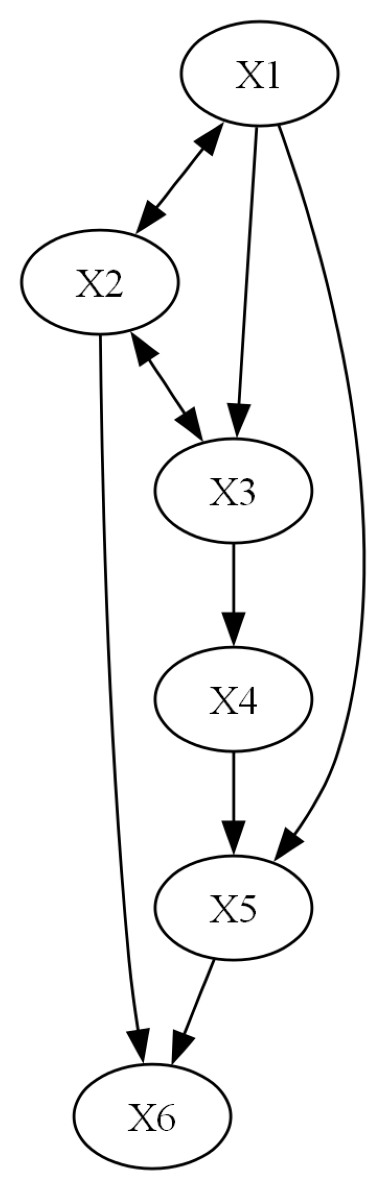

In [20]:
true_mag.draw_pydot_graph()

In [21]:
X = gaussian_data(W, 10000)
alpha = 0.05
X[0,:]

array([1.26414888, 2.20838324, 3.49105024, 5.01408009, 6.0440756 ,
       8.01832189, 1.57921282, 0.76743473])

In [22]:
# remove confounders from X
X = X[:,:6]
X

array([[ 1.26414888,  2.20838324,  3.49105024,  5.01408009,  6.0440756 ,
         8.01832189],
       [-1.03176192, -1.74464532, -3.22009744, -3.68582719, -4.47562684,
        -8.1335524 ],
       [-2.43757931, -1.04297265, -3.27807518, -4.69037888, -5.66230942,
        -6.93105837],
       ...,
       [ 0.72333001,  1.07767398,  1.65871638,  1.93749716,  2.20845568,
         4.29334771],
       [-2.92327116, -1.31672026, -0.91912746, -0.43868085, -3.46720073,
        -5.18740362],
       [-2.42791104, -0.4335464 , -1.57591246, -0.63504768, -3.49227742,
        -4.39478084]])

In [23]:
cluster_dag = ClusterDAG(cluster_mapping = {'C1' : ['X1', 'X2', 'X3'], 'C2' : ['X4'], 'C3' : ['X5', 'X6']}, \
                         cluster_edges = [('C1', 'C2'), ('C2', 'C3'), ('C1', 'C3')], \
                         cluster_bidirected_edges= [])

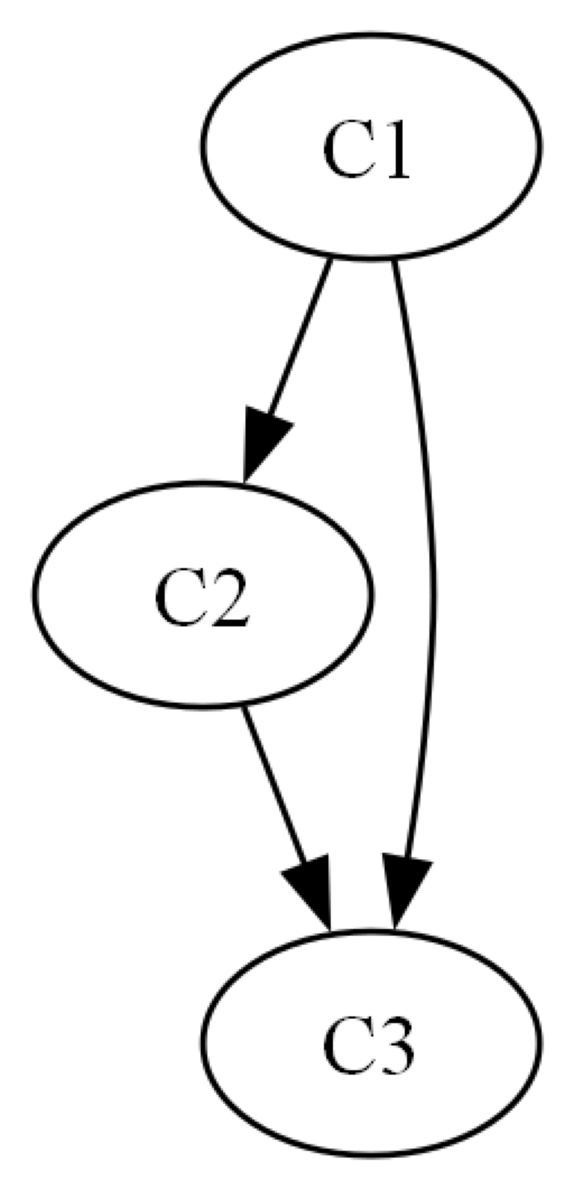

In [24]:
cluster_dag.cluster_graph.draw_pydot_graph()

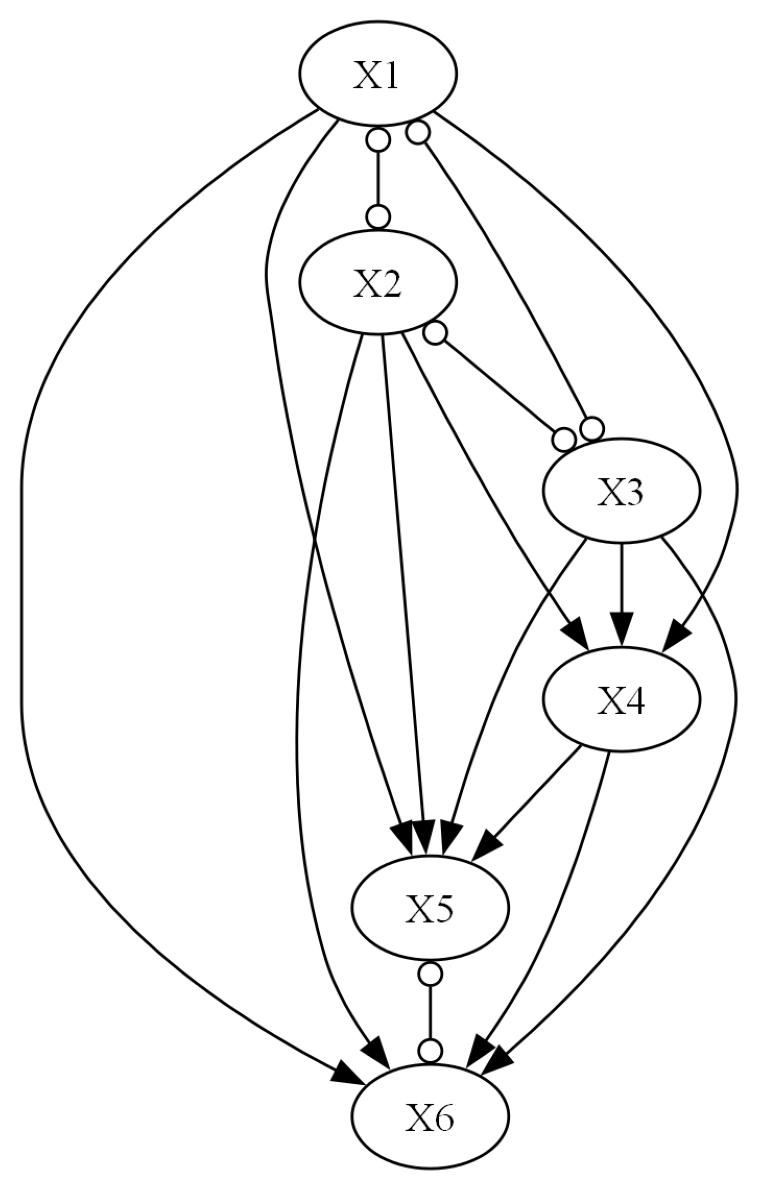

In [25]:
cluster_dag.cdag_to_circle_mpdag()
cluster_dag.cg.draw_pydot_graph()

In [26]:
cluster_fci = ClusterFCI(cluster_dag, X, alpha = 0.05, verbose = False)

In [27]:
cluster_cg, cluster_edges = cluster_fci.run()

C1 phase, Depth=0, working on node 0:  33%|███▎      | 1/3 [00:00<?, ?it/s]

C3 phase, Depth=2, working on node 5: 100%|██████████| 2/2 [00:00<00:00, 132.11it/s, duration: 0.02sec]

X4 --> X5
X5 --> X6


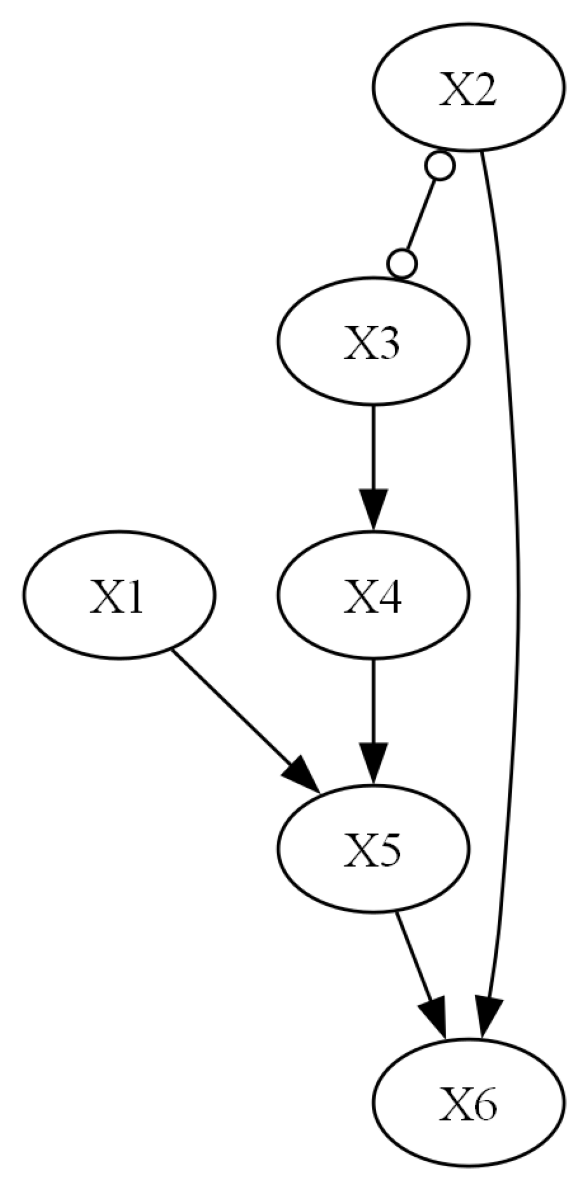

In [28]:
cluster_cg.draw_pydot_graph()

In [29]:
tiers = cluster_dag.get_cluster_topological_ordering()
cluster_mapping = cluster_dag.cluster_mapping
fci_tiers_cg, fci_tiers_edges = fci_tiers(tiers = tiers, \
                                          cluster_mapping = cluster_mapping, \
                                          cdag = cluster_dag, \
                                            dataset = X, alpha = 0.05, \
                                                verbose = False)

Depth=2, working on node 5: 100%|██████████| 6/6 [00:00<?, ?it/s]

X4 --> X5
X5 --> X6


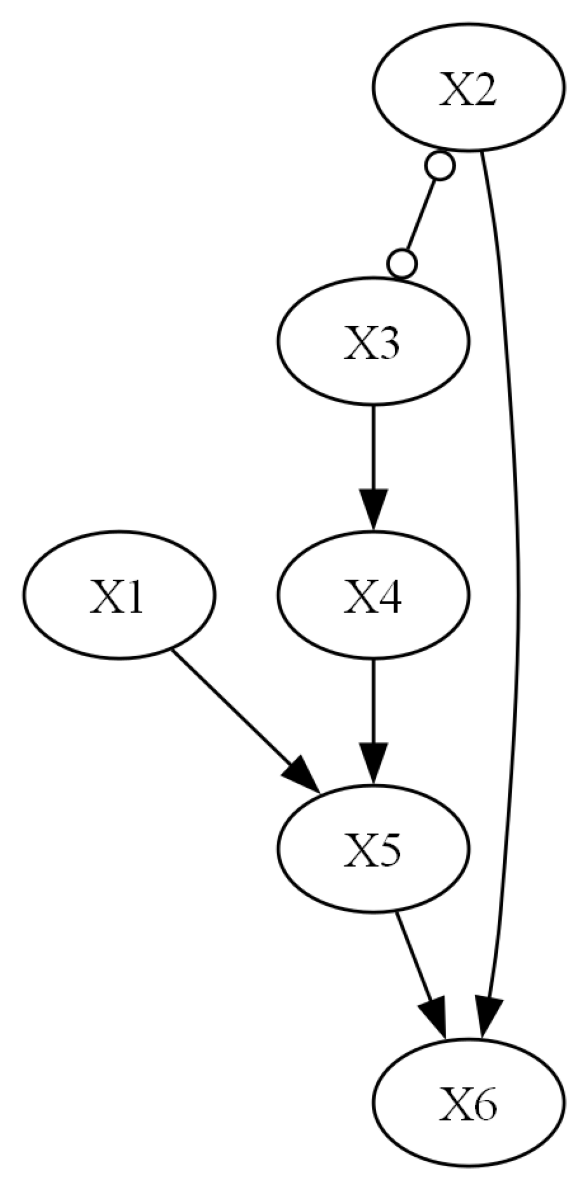

In [30]:
fci_tiers_cg.draw_pydot_graph()

In [31]:
base_G, base_edges = fci(X, alpha = 0.05, verbose = False)
base_cg = CausalGraph(5)
# node_names = ['X3', 'X4', 'X5']
# for i in range(len(node_names)):
#     base_G.nodes[i].name = node_names[i]
base_G.get_node_names()
base_cg.G = base_G
print("WARNING: FCI doesn't support custom node names!")

Depth=2, working on node 5: 100%|██████████| 6/6 [00:00<00:00, 372.68it/s] 

X5 --> X6


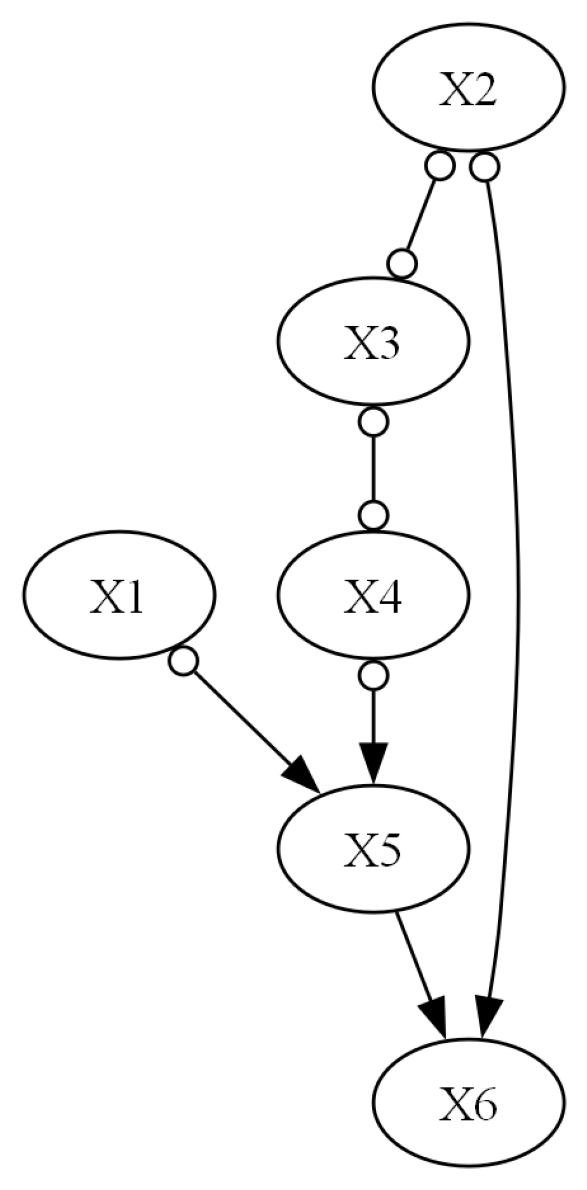

In [32]:
base_cg.draw_pydot_graph()

SID is set to false, as SID is not defined for PAGs. Its outputs do not make sense. 

In [33]:
# Evaluator works on the GeneralGraph object of a CausalGraph object, which is cg.G, cluster_dag.true_dag.G or pc_est_graph.G
eval_fci = Evaluator(truth = true_mag.G, est = base_cg.G)
adjacency_confusion, arrow_confusion, shd, sid = eval_fci.get_causallearn_metrics(sid = False)
print("Adjacency confusion: ", adjacency_confusion)
print("Arrow confusion: ", arrow_confusion)
print("SHD: ", shd)
print("SID: ",  sid)

Adjacency confusion:  {'true_positive': 6, 'false_positive': 0, 'false_negative': 2, 'true_negative': 7, 'precision': 1.0, 'recall': 0.75, 'f1_score': 0.8571428571428571}
Arrow confusion:  {'true_positive': 4.0, 'false_positive': 0.0, 'false_negative': 6.0, 'true_negative': 26.0, 'precision': 1.0, 'recall': 0.4, 'f1_score': 0.5714285714285715, 'true_positive_ce': 4.0, 'false_positive_ce': 0.0, 'false_negative_ce': 3.0, 'true_negative_ce': 29.0, 'precision_ce': 1.0, 'recall_ce': 0.5714285714285714, 'f1_score_ce': 0.7272727272727273}
SHD:  2
SID:  {'sid_lower': None}


In [34]:
# Evaluator works on the GeneralGraph object of a CausalGraph object, which is cg.G, cluster_dag.true_dag.G or pc_est_graph.G
eval_c_fci = Evaluator(truth = true_mag.G, est = cluster_cg.G)
adjacency_confusion, arrow_confusion, shd, sid = eval_c_fci.get_causallearn_metrics(sid = False)
print("Adjacency confusion: ", adjacency_confusion)
print("Arrow confusion: ", arrow_confusion)
print("SHD: ", shd)
print("SID: ",  sid)

Adjacency confusion:  {'true_positive': 6, 'false_positive': 0, 'false_negative': 2, 'true_negative': 7, 'precision': 1.0, 'recall': 0.75, 'f1_score': 0.8571428571428571}
Arrow confusion:  {'true_positive': 5.0, 'false_positive': 0.0, 'false_negative': 5.0, 'true_negative': 26.0, 'precision': 1.0, 'recall': 0.5, 'f1_score': 0.6666666666666666, 'true_positive_ce': 5.0, 'false_positive_ce': 0.0, 'false_negative_ce': 2.0, 'true_negative_ce': 29.0, 'precision_ce': 1.0, 'recall_ce': 0.7142857142857143, 'f1_score_ce': 0.8333333333333333}
SHD:  2
SID:  {'sid_lower': None}


In [35]:
eval_fci_tiers = Evaluator(truth = true_mag.G, est = fci_tiers_cg.G)
adjacency_confusion, arrow_confusion, shd, sid = eval_fci_tiers.get_causallearn_metrics(sid = False)
print("Adjacency confusion: ", adjacency_confusion)
print("Arrow confusion: ", arrow_confusion)
print("SHD: ", shd)
print("SID: ",  sid)

Adjacency confusion:  {'true_positive': 6, 'false_positive': 0, 'false_negative': 2, 'true_negative': 7, 'precision': 1.0, 'recall': 0.75, 'f1_score': 0.8571428571428571}
Arrow confusion:  {'true_positive': 5.0, 'false_positive': 0.0, 'false_negative': 5.0, 'true_negative': 26.0, 'precision': 1.0, 'recall': 0.5, 'f1_score': 0.6666666666666666, 'true_positive_ce': 5.0, 'false_positive_ce': 0.0, 'false_negative_ce': 2.0, 'true_negative_ce': 29.0, 'precision_ce': 1.0, 'recall_ce': 0.7142857142857143, 'f1_score_ce': 0.8333333333333333}
SHD:  2
SID:  {'sid_lower': None}


load from a graph

In [36]:
base_cg, cluster_cg, tiers_cg, cdag = load_experiment_graphs("clustercausal\experiments\_results\ClusterFCI_2024-12-20 11-58-31.118336\erdos_renyi_15_nodes_30_edges_7_clusters_gauss_run10_12-04-27-676")

UnboundLocalError: cannot access local variable 'base_est_graph' where it is not associated with a value

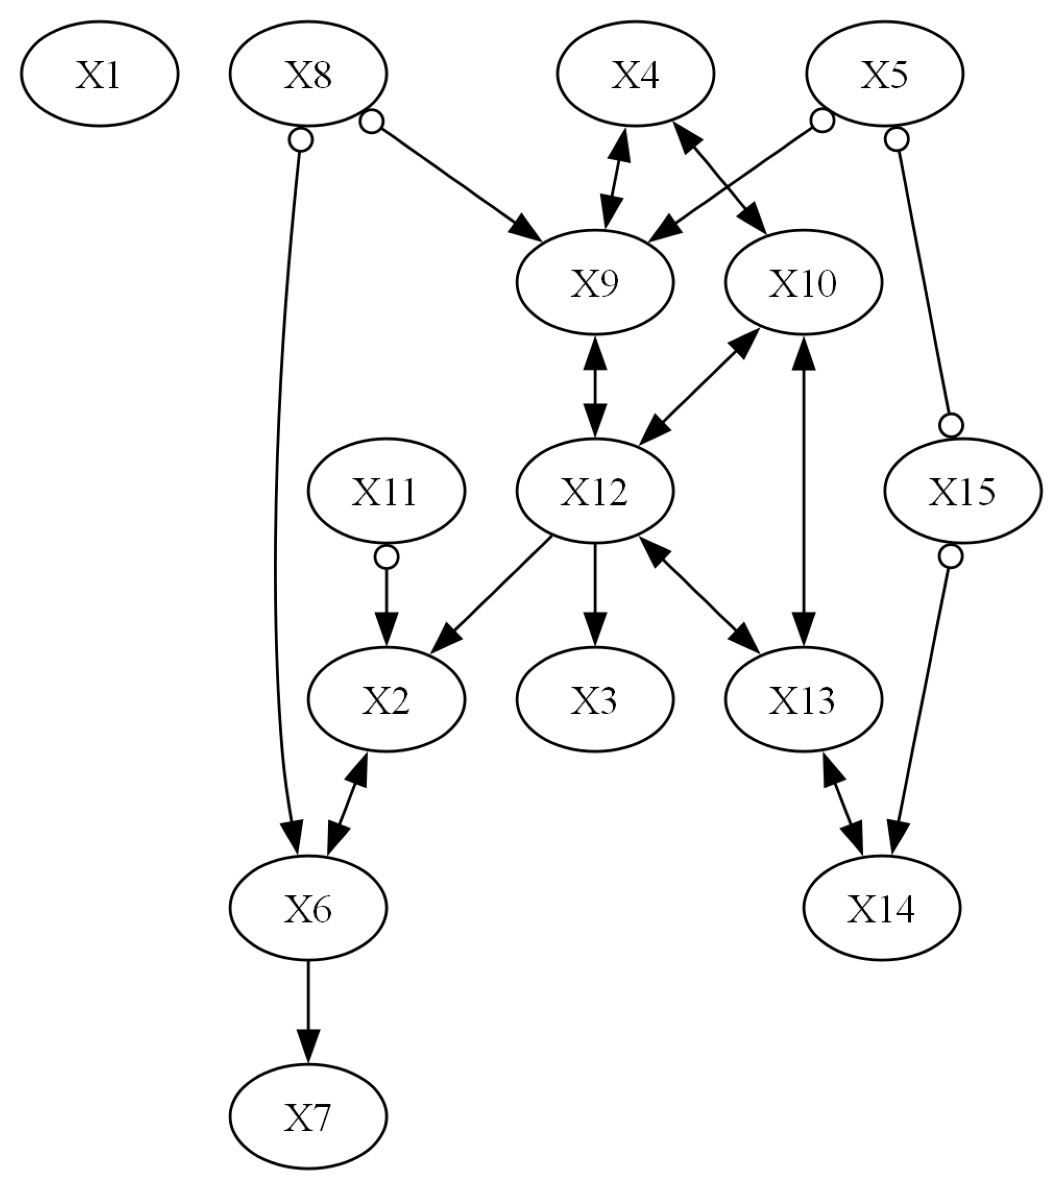

In [ ]:
base_cg.draw_pydot_graph()

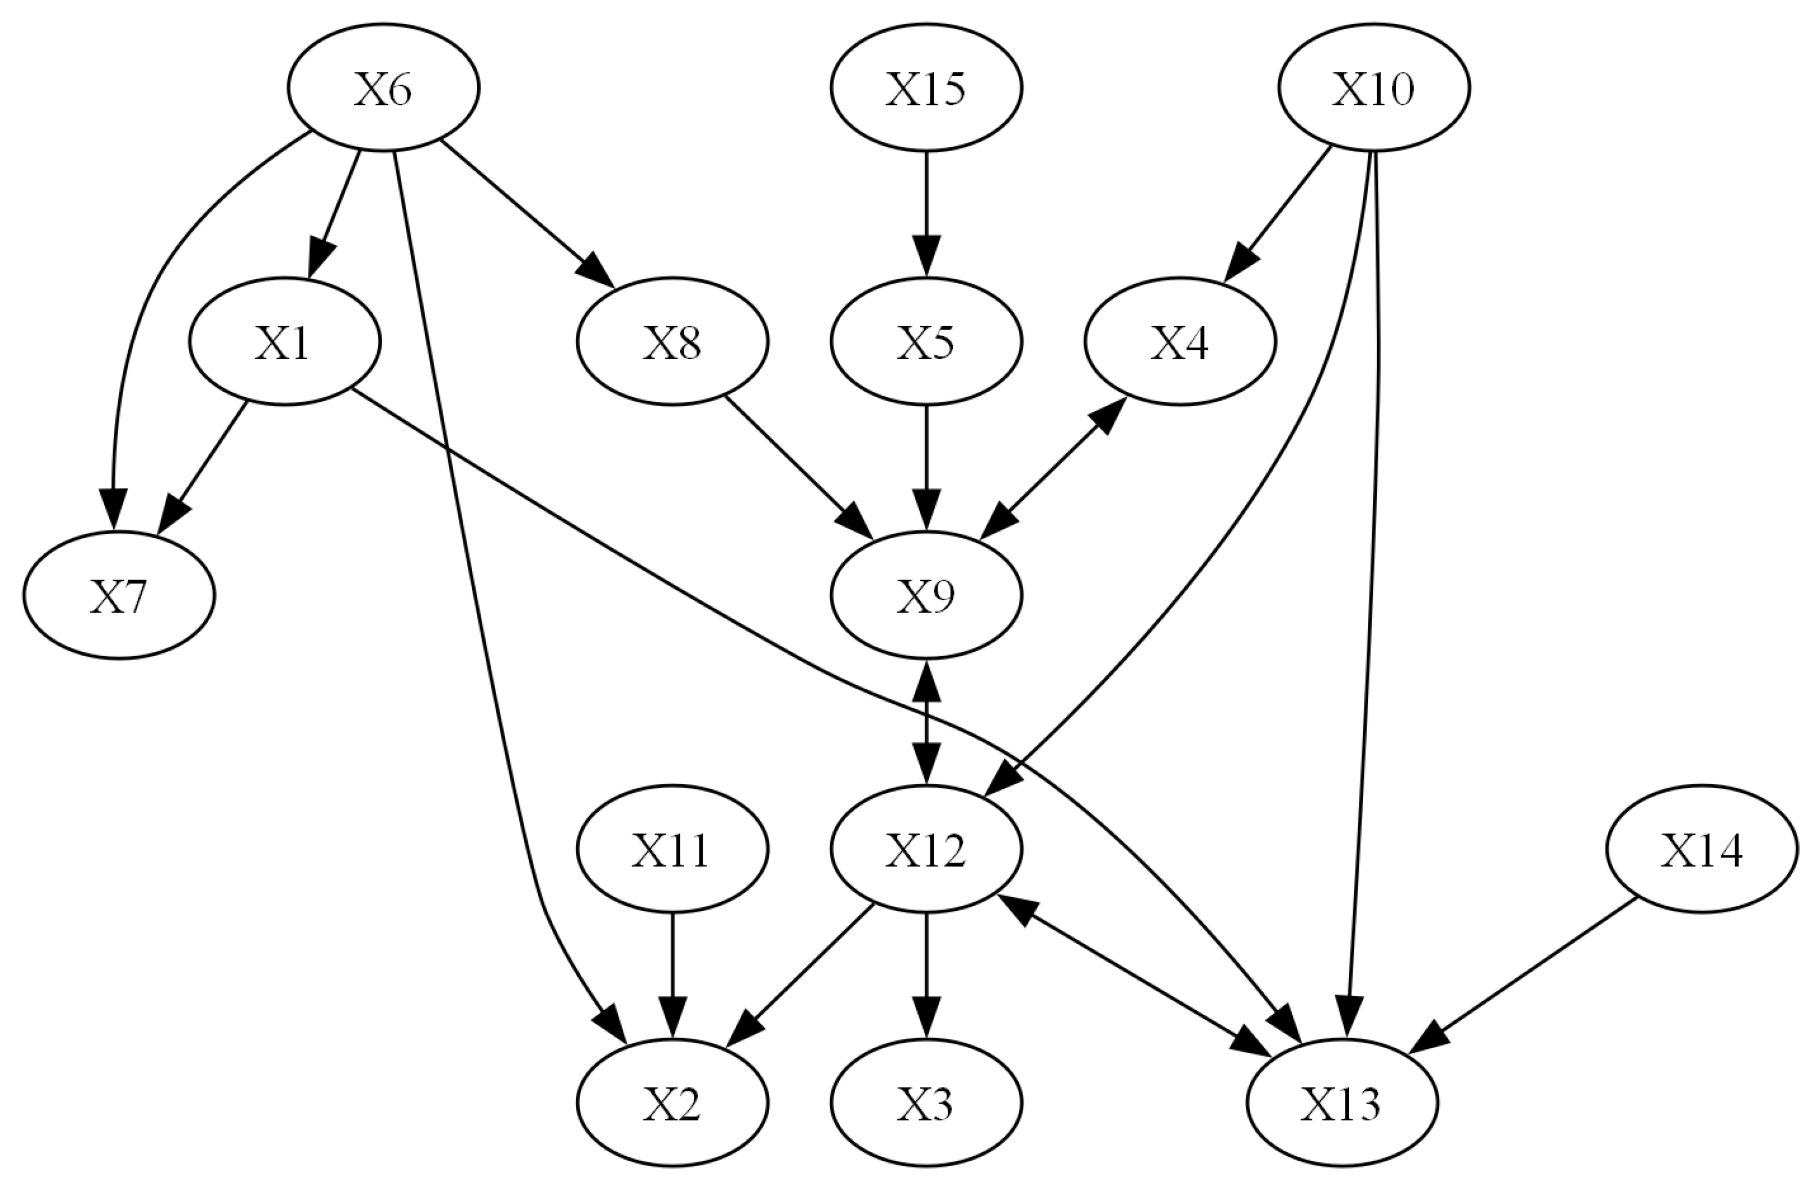

In [ ]:
tiers_cg.draw_pydot_graph()

In [ ]:
# clustercausal\experiments\_results\ClusterFCI_2024-12-20 11-58-31.118336\erdos_renyi_15_nodes_30_edges_7_clusters_gauss_run10_12-04-27-676\results.yaml
# read yaml
with open("clustercausal\experiments\_results\ClusterFCI_2024-12-20 11-58-31.118336\erdos_renyi_15_nodes_30_edges_7_clusters_gauss_run10_12-04-27-676\\results.yaml") as file:
    results = yaml.load(file, Loader=yaml.FullLoader)
pd.DataFrame(results)

base_evaluation_results  cluster_evaluation_results  \
adj_f1_score                            0.629630                    0.678571   
adj_false_negative                     20.000000                   18.000000   
adj_false_positive                      0.000000                    0.000000   
adj_precision                           1.000000                    1.000000   
adj_recall                              0.459459                    0.513514   
adj_true_negative                      68.000000                   68.000000   
adj_true_positive                      17.000000                   19.000000   
arrow_f1_score                          0.438356                    0.605263   
arrow_f1_score_ce                       0.761905                    0.920000   
arrow_false_negative                   33.000000                   26.000000   
arrow_false_negative_ce                 2.000000                    0.000000   
arrow_false_positive                    8.000000                    4.000000   
arrow_false_positive_ce                 8.000000                    4.000000   
arrow_precision                         0.666667                    0.851852   
arrow_precision_ce                      0.666667                    0.851852   
arrow_recall                            0.326531                    0.469388   
arrow_recall_ce                         0.888889                    1.000000   
arrow_true_negative                   168.000000                  172.000000   
arrow_true_negative_ce                199.000000                  198.000000   
arrow_true_positive                    16.000000                   23.000000   
arrow_true_positive_ce                 16.000000                   23.000000   
base_shd                               30.000000                         NaN   
sid_lower                                    NaN                         NaN   
cluster_shd                                  NaN                   30.000000   
fcitiers_shd                                 NaN                         NaN   
pruned_base_shd                              NaN                         NaN   
Base indep tests                             NaN                         NaN   
Cluster indep tests                          NaN                         NaN   
alpha                                        NaN                         NaN   
cluster_connectivity                         NaN                         NaN   
dag_method                                   NaN                         NaN   
distribution_type                            NaN                         NaN   
edge_ratios                                  NaN                         NaN   
empty_graph_shd                              NaN                         NaN   
indep_test                                   NaN                         NaN   
n_clusters                                   NaN                         NaN   
n_edges                                      NaN                         NaN   
n_nodes                                      NaN                         NaN   
noise_scale                                  NaN                         NaN   
sample_size                                  NaN                         NaN   
scm_method                                   NaN                         NaN   
seed                                         NaN                         NaN   
true_sid_lower                               NaN                         NaN   
true_sid_upper                               NaN                         NaN   
weight_range                                 NaN                         NaN   

                         fcitiers_evaluation_results  \
adj_f1_score                                0.678571   
adj_false_negative                         18.000000   
adj_false_positive                          0.000000   
adj_precision                               1.000000   
adj_recall                                  0.513514   
adj_true

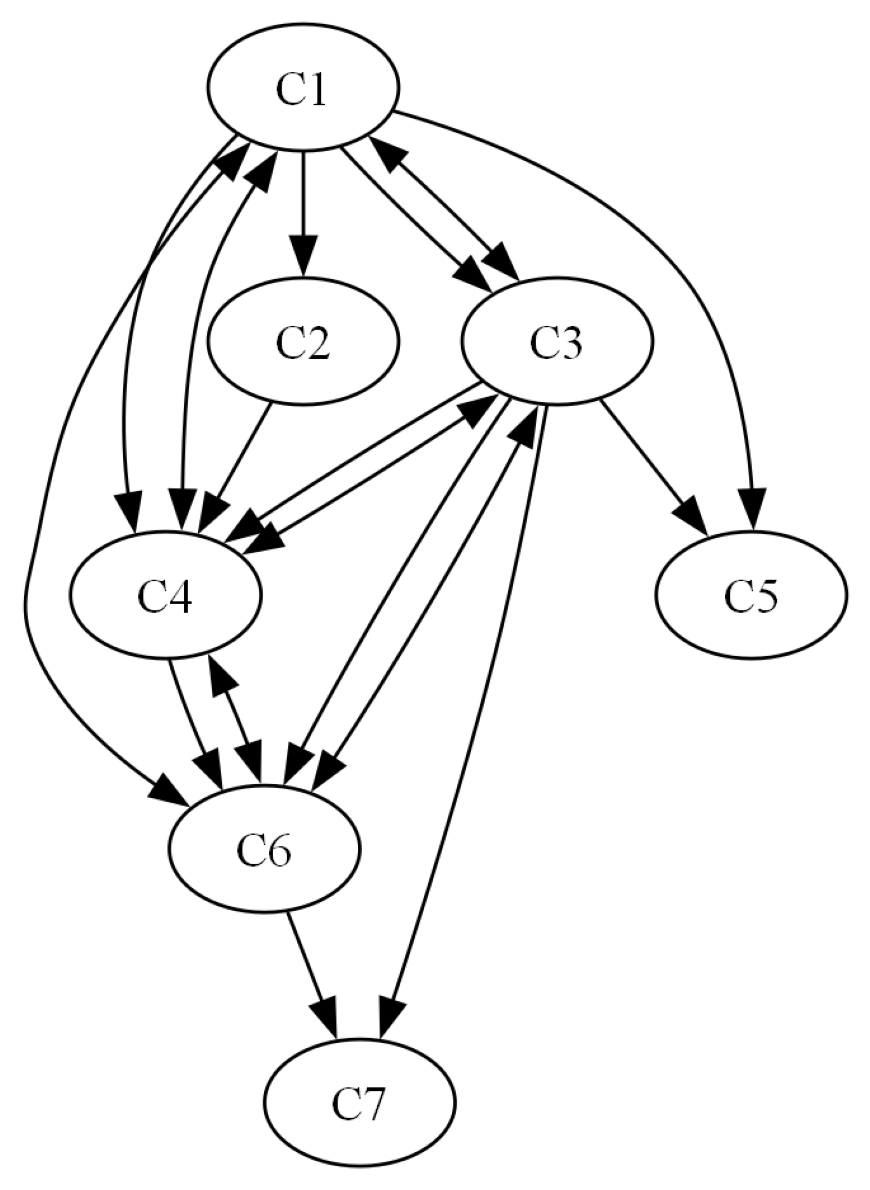

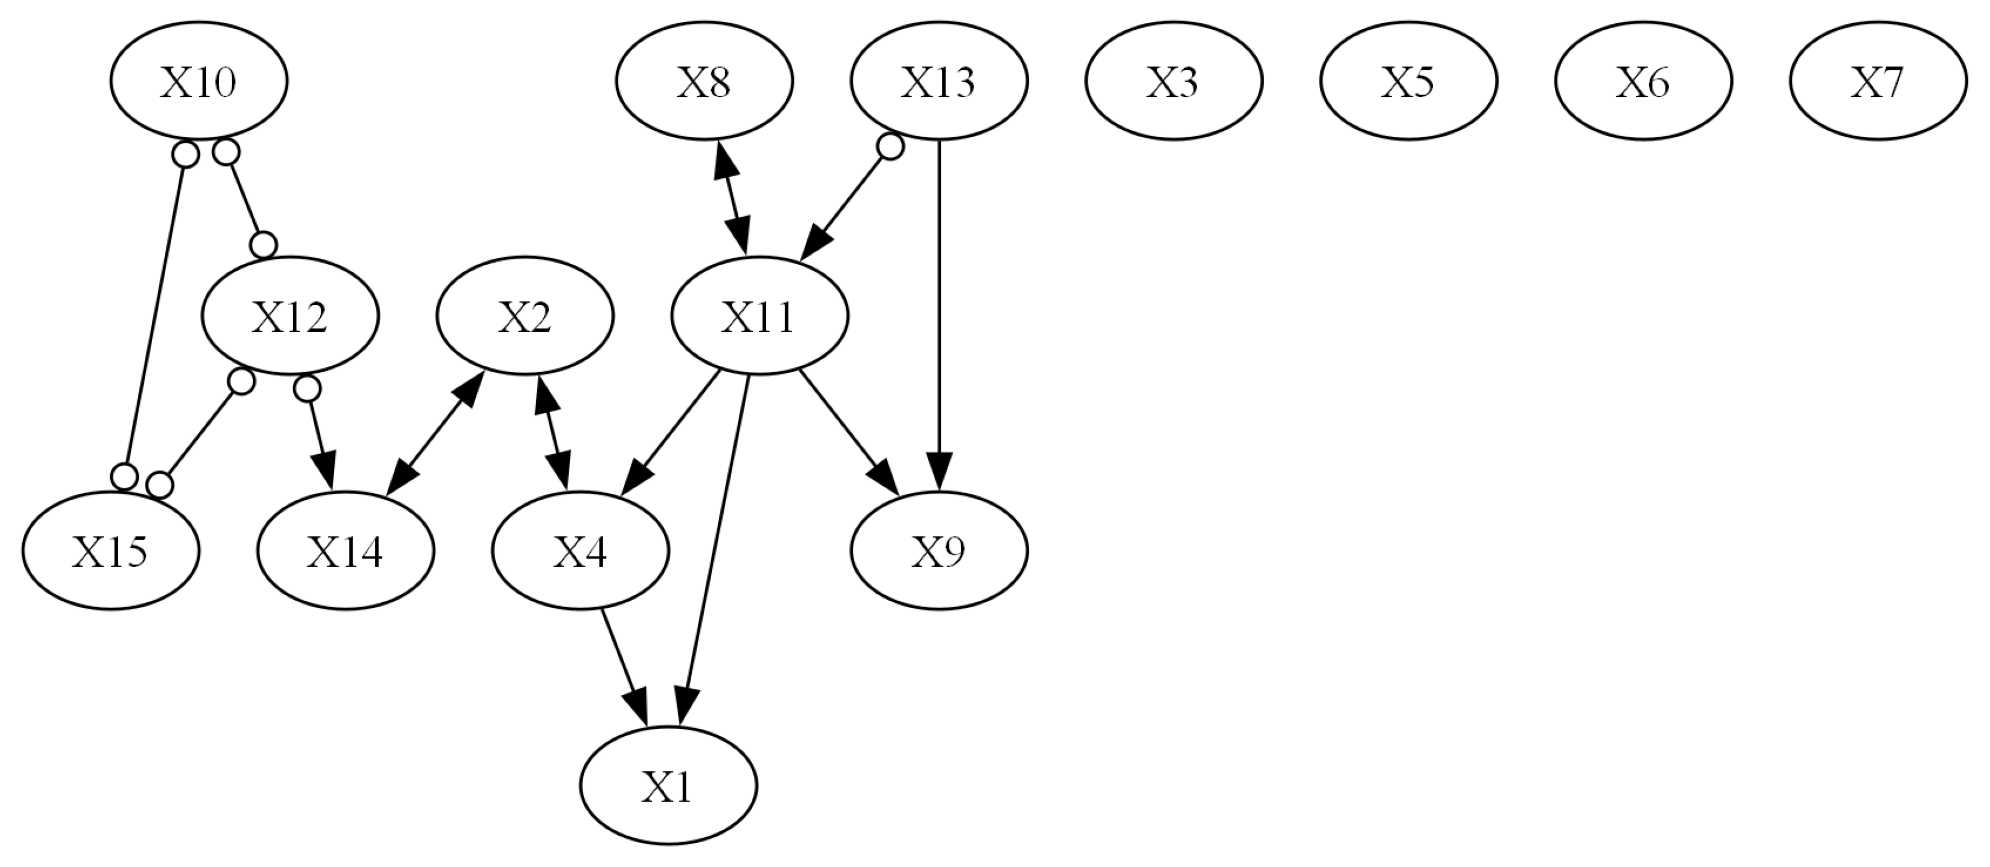

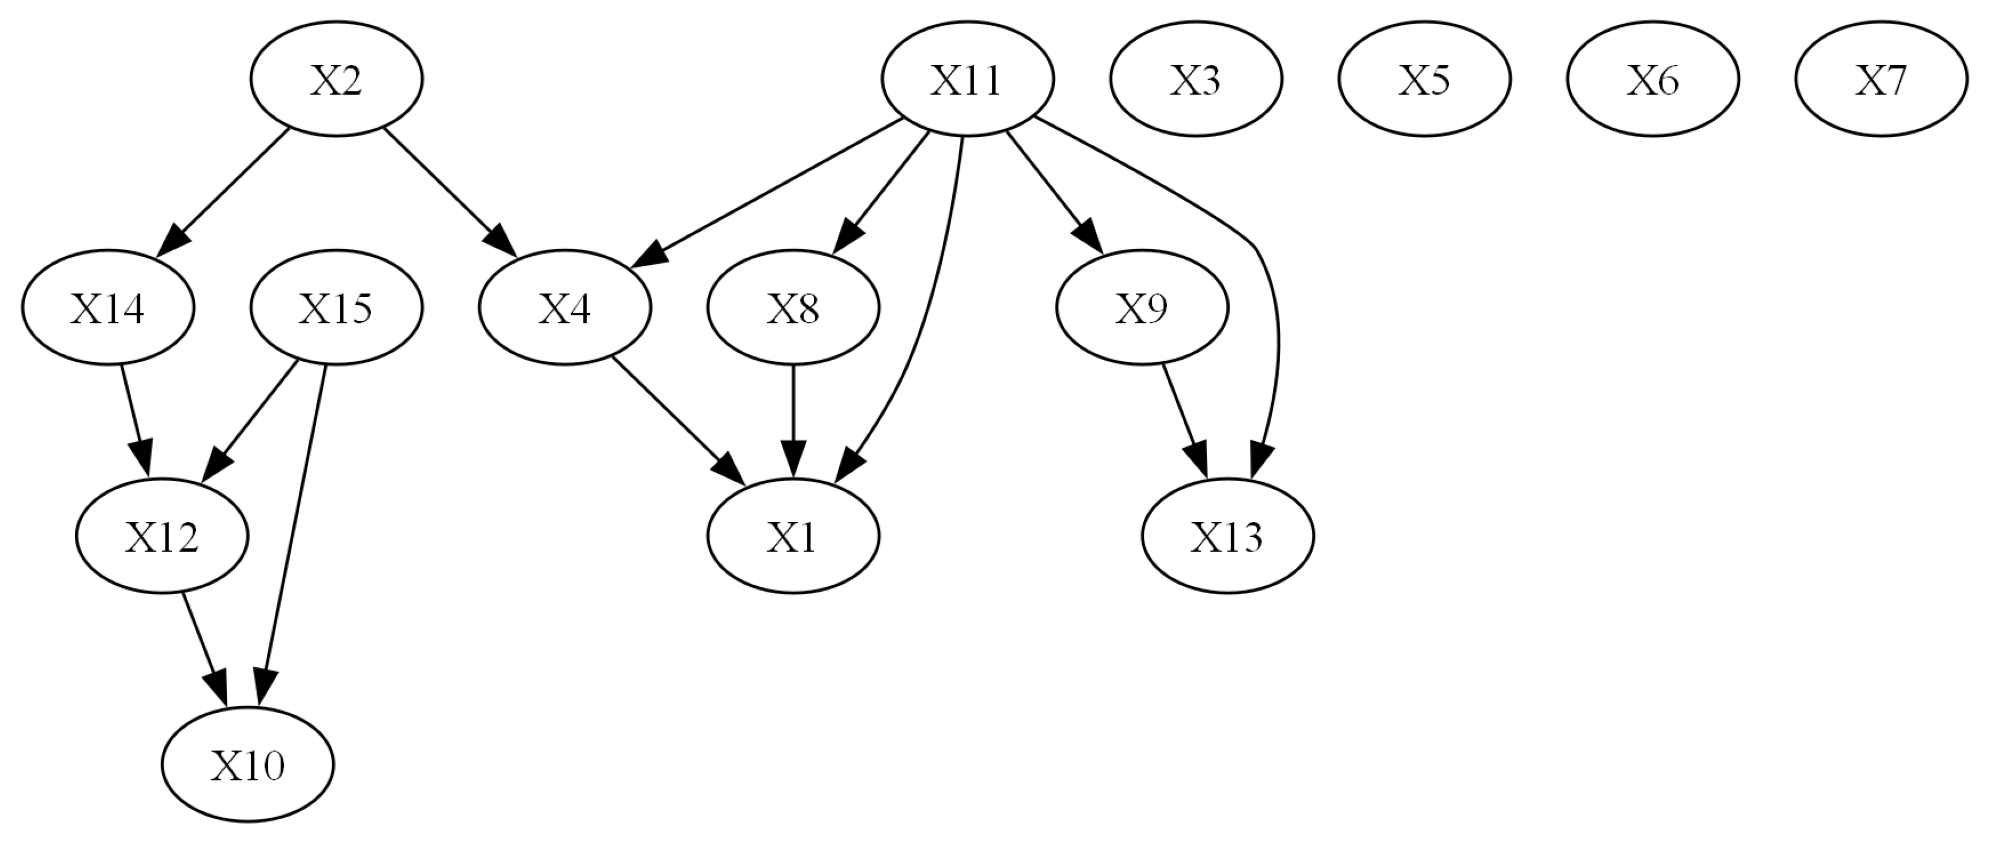

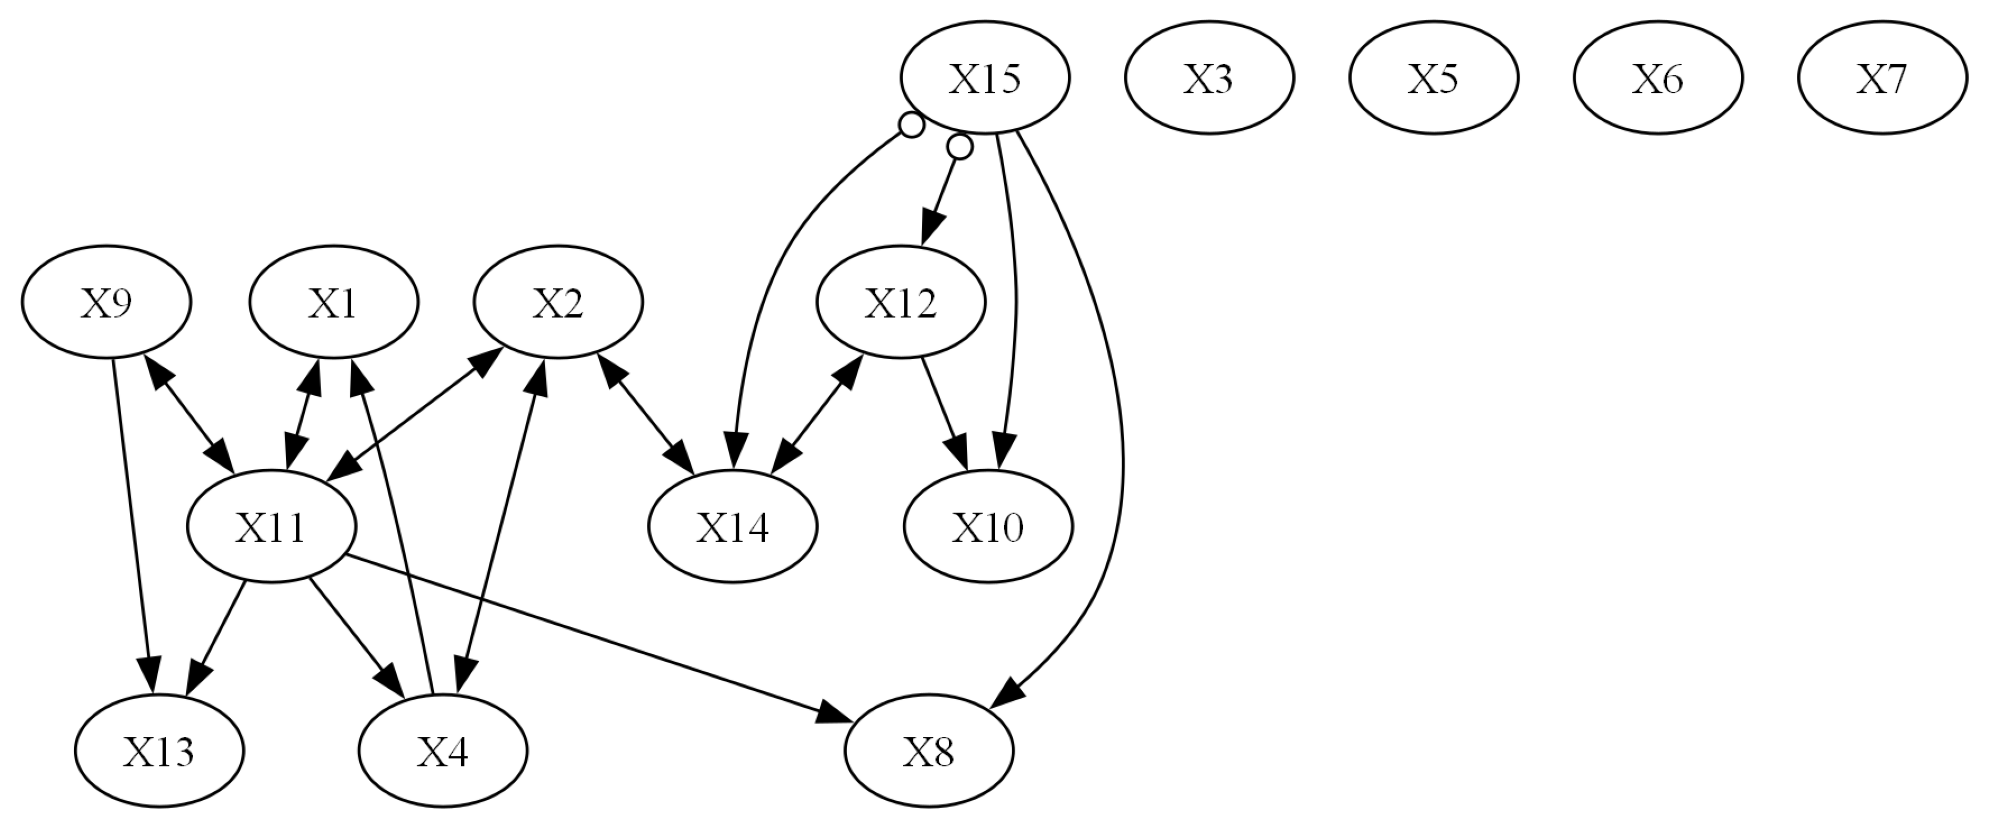

base_evaluation_results  cluster_evaluation_results  \
adj_f1_score                            0.533333                    0.625000   
adj_false_negative                     20.000000                   17.000000   
adj_false_positive                      1.000000                    1.000000   
adj_precision                           0.923077                    0.937500   
adj_recall                              0.375000                    0.468750   
adj_true_negative                      72.000000                   72.000000   
adj_true_positive                      12.000000                   15.000000   
arrow_f1_score                          0.307692                    0.557377   
arrow_f1_score_ce                       0.592593                    0.850000   
arrow_false_negative                   31.000000                   22.000000   
arrow_false_negative_ce                 7.000000                    2.000000   
arrow_false_positive                    5.000000                    5.000000   
arrow_false_positive_ce                 4.000000                    4.000000   
arrow_precision                         0.615385                    0.772727   
arrow_precision_ce                      0.666667                    0.809524   
arrow_recall                            0.205128                    0.435897   
arrow_recall_ce                         0.533333                    0.894737   
arrow_true_negative                   181.000000                  181.000000   
arrow_true_negative_ce                206.000000                  202.000000   
arrow_true_positive                     8.000000                   17.000000   
arrow_true_positive_ce                  8.000000                   17.000000   
base_shd                               28.000000                         NaN   
sid_lower                                    NaN                         NaN   
cluster_shd                                  NaN                   28.000000   
fcitiers_shd                                 NaN                         NaN   
pruned_base_shd                              NaN                         NaN   
Base indep tests                             NaN                         NaN   
Cluster indep tests                          NaN                         NaN   
alpha                                        NaN                         NaN   
cluster_connectivity                         NaN                         NaN   
dag_method                                   NaN                         NaN   
distribution_type                            NaN                         NaN   
edge_ratios                                  NaN                         NaN   
empty_graph_shd                              NaN                         NaN   
indep_test                                   NaN                         NaN   
n_clusters                                   NaN                         NaN   
n_edges                                      NaN                         NaN   
n_nodes                                      NaN                         NaN   
noise_scale                                  NaN                         NaN   
sample_size                                  NaN                         NaN   
scm_method                                   NaN                         NaN   
seed                                         NaN                         NaN   
true_sid_lower                               NaN                         NaN   
true_sid_upper                               NaN                         NaN   
weight_range                                 NaN                         NaN   

                         fcitiers_evaluation_results  \
adj_f1_score                                0.521739   
adj_false_negative                         20.000000   
adj_false_positive                          2.000000   
adj_precision                               0.857143   
adj_recall                                  0.375000   
adj_true

In [ ]:
#clustercausal\experiments\_results\ClusterFCI_2024-12-20 11-58-31.118336\erdos_renyi_15_nodes_20_edges_7_clusters_gauss_run8_11-59-40-170
path = "clustercausal\experiments\_results\ClusterFCI_2024-12-20 11-58-31.118336\erdos_renyi_15_nodes_20_edges_7_clusters_gauss_run8_11-59-40-170"
base_cg, cluster_cg, tiers_cg, cdag = load_experiment_graphs(path)
cdag.cluster_mapping
cdag.cluster_graph.draw_pydot_graph()
base_cg.draw_pydot_graph()
tiers_cg.draw_pydot_graph()
cluster_cg.draw_pydot_graph()
with open(f"{path}\\results.yaml") as file:
    results = yaml.load(file, Loader=yaml.FullLoader)
pd.DataFrame(results)